In [84]:
from IPython.display import Image
from torch.utils.data import IterableDataset, DataLoader, Dataset
from transformers import AutoTokenizer
from datasets import load_dataset
import numpy as np
from tqdm import tqdm

In [33]:
rng = np.random.default_rng()

## basics

- dataloader 是对 dataset 的进一步封装（批次化的 load）
- mapping 与 streaming
    - mapping：
        - Arrow dataset（columnar format，table-like）: high-performance data processing (access)
        - Maps a portion of a file or an entire file on disk To a chunk of virtual memory；
            - 这样每次都可只 access segments 而不需首先 load 全部进内存；
    - streaming (IterableDataset)：处理超出内存/硬盘空间的数据集；
- misc
    - single/multi process data loading
    - `worker_info = torch.utils.data.get_worker_info()`
        - 单进程时，`worker_info` 为 `none`；
        - 多进程时，查看 workers 数量 `worker_info.num_workers`

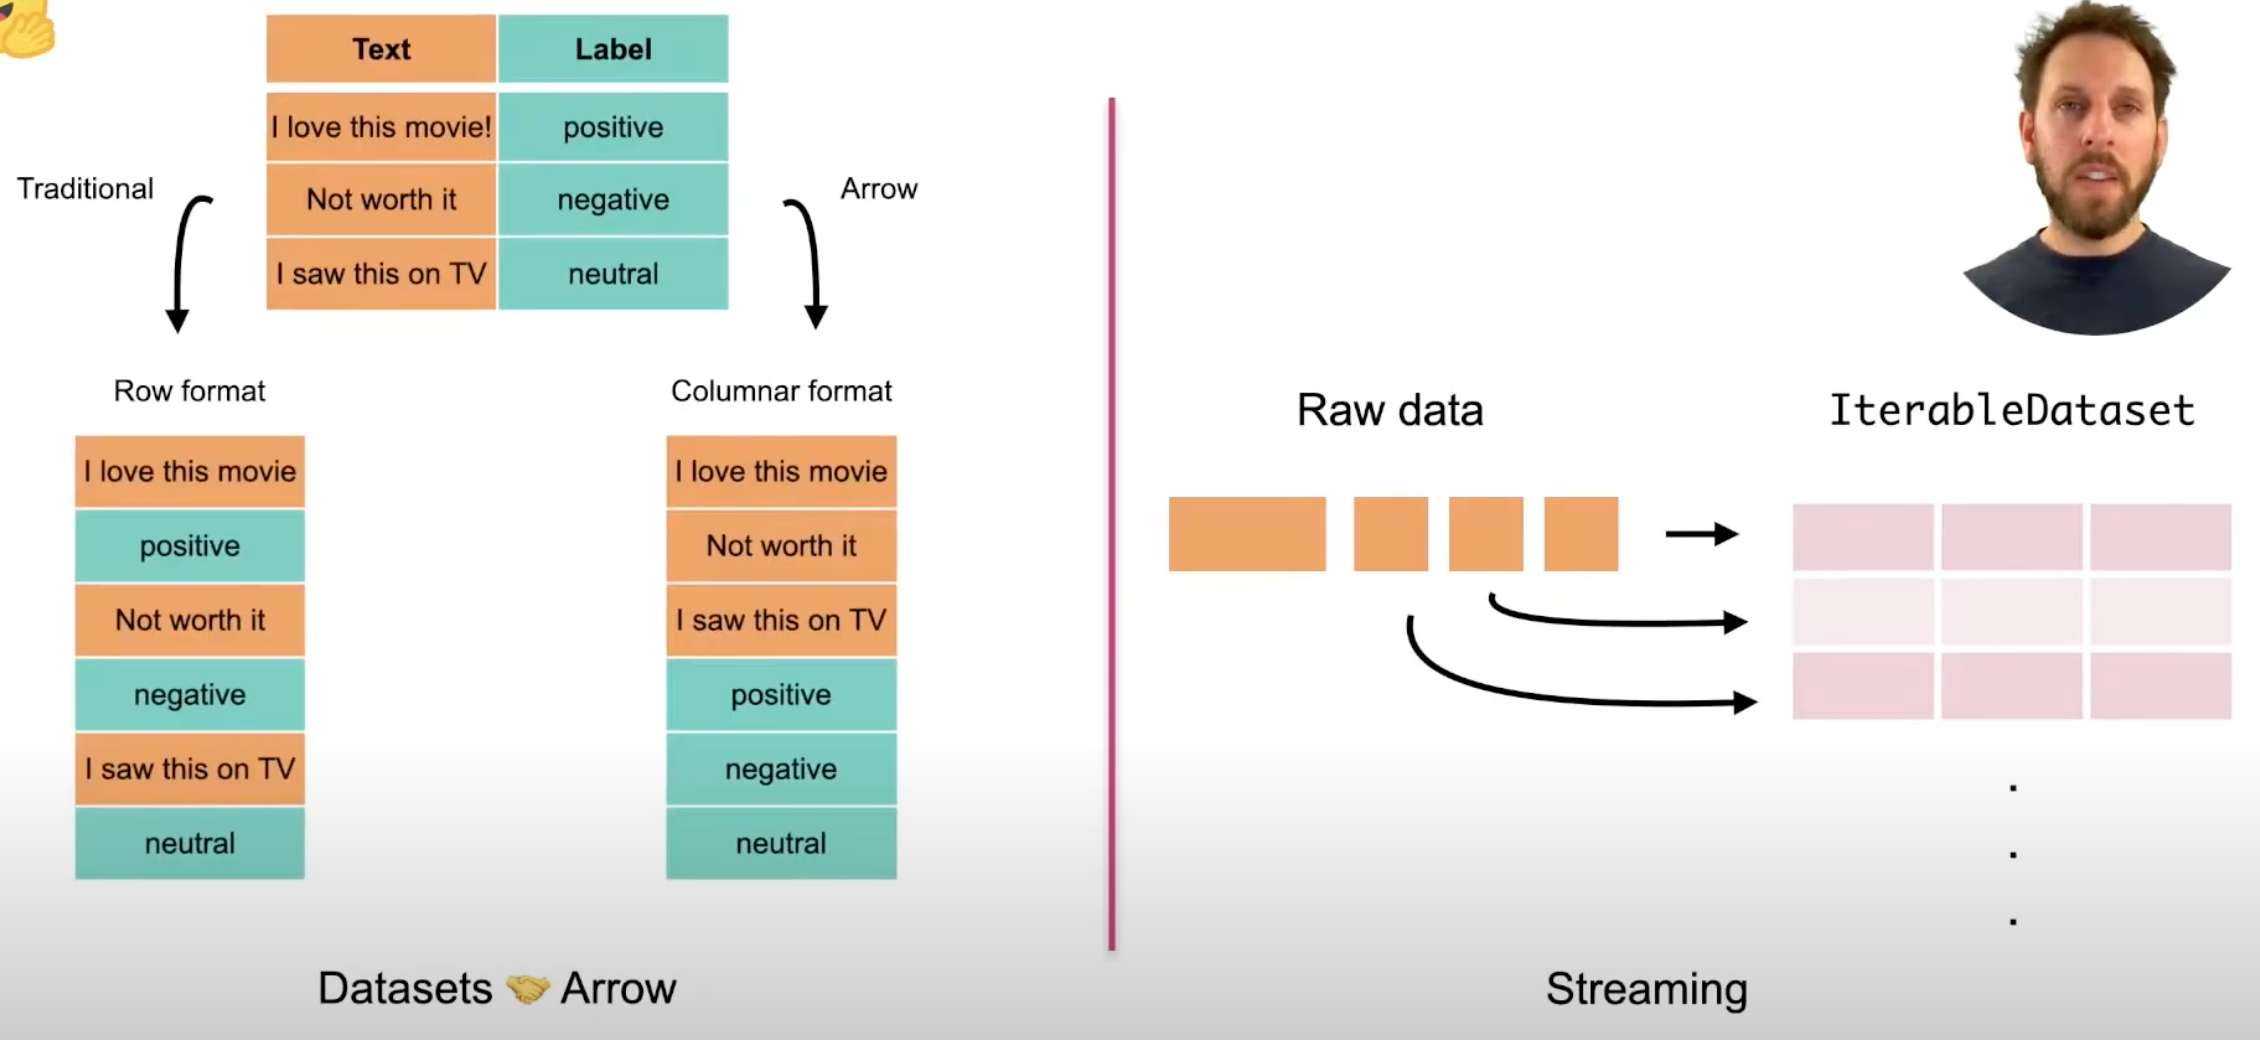

In [83]:
# arrow
# table-like dataset
Image('../imgs/datasets-style.png', width=700)

### memory mapped

In [40]:
# kaggle 下载：https://www.kaggle.com/datasets/tunguz/pubmed-title-abstracts-2019-baseline?resource=download
data_files = "/media/whaow/datasets/PUBMED_title_abstracts_2019_baseline.jsonl"
large_dataset = load_dataset("json", data_files=data_files, split="train")
size_gb = large_dataset.dataset_size / (1024 ** 3)
print(f"Dataset size (cache file) : {size_gb:.2f} GB")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /media/whaow/.cache/huggingface/datasets/json/default-76c94cb06ce44dd3/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51. Subsequent calls will reuse this data.
Dataset size (cache file) : 19.54 GB


In [41]:
import psutil
print(f'{psutil.Process().memory_info().rss/(1024**2):.2f} MB')

1570.01 MB


In [95]:
type(large_dataset)

datasets.arrow_dataset.Dataset

In [96]:
# print(large_dataset[0])
len(large_dataset)

15518009

In [54]:
import timeit
code_snippet = '''batch_size = 20000
for idx in tqdm(range(0, len(large_dataset), batch_size)):
    _ = large_dataset[idx: idx+batch_size]
'''
duration = timeit.timeit(stmt=code_snippet, number=2, globals=globals())

100%|██████████| 776/776 [01:10<00:00, 10.96it/s]


In [55]:
duration

141.20555789401988

In [97]:
f'{size_gb}/{duration/2}: {size_gb/(duration/2):.3f} GB/s'

'19.538116226904094/70.60277894700994: 0.277 GB/s'

### streaming (Dataset => IterableDataset)

In [77]:
data_files = "/media/whaow/datasets/PUBMED_title_abstracts_2019_baseline.jsonl"
large_dataset_streamed = load_dataset("json", data_files=data_files, split="train", streaming=True)

In [60]:
type(large_dataset_streamed)

datasets.iterable_dataset.IterableDataset

In [59]:
next(iter(large_dataset_streamed))

{'meta': {'pmid': 11409574, 'language': 'eng'},
 'text': 'Epidemiology of hypoxaemia in children with acute lower respiratory infection.\nTo determine the prevalence of hypoxaemia in children aged under 5 years suffering acute lower respiratory infections (ALRI), the risk factors for hypoxaemia in children under 5 years of age with ALRI, and the association of hypoxaemia with an increased risk of dying in children of the same age. Systematic review of the published literature. Out-patient clinics, emergency departments and hospitalisation wards in 23 health centres from 10 countries. Cohort studies reporting the frequency of hypoxaemia in children under 5 years of age with ALRI, and the association between hypoxaemia and the risk of dying. Prevalence of hypoxaemia measured in children with ARI and relative risks for the association between the severity of illness and the frequency of hypoxaemia, and between hypoxaemia and the risk of dying. Seventeen published studies were found that i

In [100]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
# tokenizer_dataset2 = large_dataset.map(lambda x: tokenizer(x['text']), batched=True, batch_size=20000)
tokenizer_dataset = large_dataset_streamed.map(lambda x: tokenizer(x['text']))

In [101]:
next(iter(tokenizer_dataset)).keys()

dict_keys(['meta', 'text', 'input_ids', 'attention_mask'])

In [72]:
list(large_dataset_streamed.take(5))[-1]

{'meta': {'pmid': 11409578, 'language': 'eng'},
 'text': 'Oxygen supply in rural africa: a personal experience.\nOxygen is one of the essential medical supplies in any hospital setting. However, in some rural African settings without regular electricity and with logistical problems in the transport of oxygen cylinders, the delivery of oxygen can be difficult. This paper compares the costs incurred using oxygen cylinders with a solar operated oxygen concentrator in a rural Gambian setting. The paper shows that a solar operated system has a high capital investment initially, but that running costs and maintenance are minimal. The system becomes cost effective if a rural hospital needs more than 6 treatment days (1 l/min) of oxygen per month and can be considered in a setting where 6 hours of sunlight per day can be guaranteed.'}

In [73]:
large_dataset[4]

{'meta': {'pmid': 11409578, 'language': 'eng'},
 'text': 'Oxygen supply in rural africa: a personal experience.\nOxygen is one of the essential medical supplies in any hospital setting. However, in some rural African settings without regular electricity and with logistical problems in the transport of oxygen cylinders, the delivery of oxygen can be difficult. This paper compares the costs incurred using oxygen cylinders with a solar operated oxygen concentrator in a rural Gambian setting. The paper shows that a solar operated system has a high capital investment initially, but that running costs and maintenance are minimal. The system becomes cost effective if a rural hospital needs more than 6 treatment days (1 l/min) of oxygen per month and can be considered in a setting where 6 hours of sunlight per day can be guaranteed.'}

In [81]:
next(iter(large_dataset_streamed.skip(1000)))

{'meta': {'pmid': 11410926, 'language': 'eng'},
 'text': 'Transcarpal motor conduction velocity in carpal tunnel syndrome.\nTranscarpal motor conduction to abductor pollicis brevis (APB) was evaluated in 43 patients (70 hands) with suspected carpal tunnel syndrome (CTS). Transcarpal motor conduction was abnormal in 80% of hands compared with 11.5% with prolongated distal motor latency from wrist stimulation. Transcarpal motor conduction was comparable in sensitivity with transcarpal sensory conduction and 2nd lumbrical-interosseous latency difference. Transcarpal motor conduction is a sensitive test for diagnosis of CTS. Sensory fibers were no more susceptible than motor fibers to compression in the carpal tunnel, and fibers to APB were as susceptible as those to the 2nd lumbrical muscle.'}

In [82]:
large_dataset[1000]

{'meta': {'pmid': 11410926, 'language': 'eng'},
 'text': 'Transcarpal motor conduction velocity in carpal tunnel syndrome.\nTranscarpal motor conduction to abductor pollicis brevis (APB) was evaluated in 43 patients (70 hands) with suspected carpal tunnel syndrome (CTS). Transcarpal motor conduction was abnormal in 80% of hands compared with 11.5% with prolongated distal motor latency from wrist stimulation. Transcarpal motor conduction was comparable in sensitivity with transcarpal sensory conduction and 2nd lumbrical-interosseous latency difference. Transcarpal motor conduction is a sensitive test for diagnosis of CTS. Sensory fibers were no more susceptible than motor fibers to compression in the carpal tunnel, and fibers to APB were as susceptible as those to the 2nd lumbrical muscle.'}

## Dataset

In [91]:
class MyDataset(Dataset):
    def __init__(self, m, n):
        self.x = np.random.randn(m, n)
        self.y = list(range(m))
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return len(self.y)

In [94]:
ds = MyDataset(100, 5)
print(len(ds))
ds[0]

100


(array([ 0.06201527, -0.77968078, -0.68125061, -1.77969614, -0.66575581]), 0)

### IterableDataset

In [2]:
class MyIterableDataset(IterableDataset):
    def __init__(self, x, y):
        super().__init__()
        self.start = x
        self.end = y
    def __iter__(self):
        return iter(range(self.start, self.end))

In [13]:
ds1 = MyIterableDataset(3, 8)
ds2 = MyIterableDataset(9, 15)
ds3 = ds1 + ds2

In [14]:
[i for i in ds1]

[3, 4, 5, 6, 7]

In [15]:
[i for i in ds3]

[3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14]

In [19]:
loader = DataLoader(ds3)
list(loader)

[tensor([3]),
 tensor([4]),
 tensor([5]),
 tensor([6]),
 tensor([7]),
 tensor([9]),
 tensor([10]),
 tensor([11]),
 tensor([12]),
 tensor([13]),
 tensor([14])]

### infinite dataset

In [23]:
class InfIterableDataset(IterableDataset):
    def __init__(self, n):
        super().__init__()
        self._n = n
    def __iter__(self):
        start = 0
        while True:
            x = np.arange(start, start + self._n)
            y = rng.choice([0, 1], size=1, p=[0.4, 0.6])
            yield x, y
            start += self._n

In [25]:
window = 5
cnt = 0
for (x, y) in InfIterableDataset(window):
    print(x, y)
    if cnt >= 5:
        break
    cnt += 1

[0 1 2 3 4] [0]
[5 6 7 8 9] [1]
[10 11 12 13 14] [1]
[15 16 17 18 19] [1]
[20 21 22 23 24] [0]
[25 26 27 28 29] [1]
